# 1 Generar trayectorias

- **openMM** (https://openmm.org/)
- AMBER (ambertools)
- MAESTRO
- GROMACS
- NAMD

In [3]:
#Descargar proteina (insulina)
!wget https://files.rcsb.org/download/1A7F.pdb

--2025-06-25 09:13:27--  https://files.rcsb.org/download/1A7F.pdb
Resolviendo files.rcsb.org (files.rcsb.org)... 18.164.21.69, 18.164.21.97, 18.164.21.40, ...
Conectando con files.rcsb.org (files.rcsb.org)[18.164.21.69]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: no especificado [application/octet-stream]
Guardando como: ‘1A7F.pdb’

1A7F.pdb                [   <=>              ]   1,18M  2,20MB/s    en 0,5s    

2025-06-25 09:13:29 (2,20 MB/s) - ‘1A7F.pdb’ guardado [1243026]



In [11]:
from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout
pdb = PDBFile('1A7F.pdb')
# Specify the forcefield
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')
modeller = Modeller(pdb.topology, pdb.positions)
modeller.deleteWater()
residues=modeller.addHydrogens(forcefield)
modeller.addSolvent(forcefield, padding=1.0*nanometer)
# Setup system and integrator
system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME, nonbondedCutoff=1.0*nanometer, constraints=HBonds)
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
simulation = Simulation(modeller.topology, system, integrator)
# Local energy minimization
simulation.context.setPositions(modeller.positions)
print("Minimizing energy")
simulation.minimizeEnergy()

Minimizing energy


In [12]:
simulation.reporters.append(PDBReporter('output.pdb', 1000))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True, volume=True))
simulation.reporters.append(StateDataReporter("md_log.txt", 100, step=True,
        potentialEnergy=True, temperature=True, volume=True))
# Local NVT equilibration
print("Running NVT")
simulation.step(10000)

Running NVT
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
1000,-161611.7147669904,289.76336294687644,111.0937939488532
2000,-160272.19457342886,297.0530748619659,111.0937939488532
3000,-160224.37052983715,304.64287755635064,111.0937939488532
4000,-160409.09147895002,303.9632538103082,111.0937939488532
5000,-160415.77606066354,295.28490380870744,111.0937939488532
6000,-160456.30243359212,297.8808201180316,111.0937939488532
7000,-160134.02738821862,301.712511596644,111.0937939488532
8000,-160706.5807737344,300.895948526129,111.0937939488532
9000,-161339.1496720582,299.471121559776,111.0937939488532
10000,-161015.33284020744,301.2579127261664,111.0937939488532


In [13]:
# Local NPT production
system.addForce(MonteCarloBarostat(1*bar, 300*kelvin))
simulation.context.reinitialize(preserveState=True)
print("Running NPT")
simulation.step(10000)

Running NPT
11000,-162765.17637953802,303.13487932462135,103.6389400959952
12000,-162422.4309642122,300.44631157069085,102.90919856734375
13000,-162632.15563149226,299.2728554205735,102.39930132036184
14000,-163021.31280095162,301.1159194305175,101.54685684782841
15000,-163312.0970137668,300.87697590777293,102.16946488485507
16000,-162580.0215409916,304.8756261215184,102.52353632103637
17000,-162572.0193659693,303.2318108818638,102.27658038409686
18000,-163281.4405085538,300.7932034072236,102.49313796135375
19000,-162848.47093118375,298.4438911511471,102.42920003337714
20000,-162704.24586797698,296.91263089670275,101.65348162186488


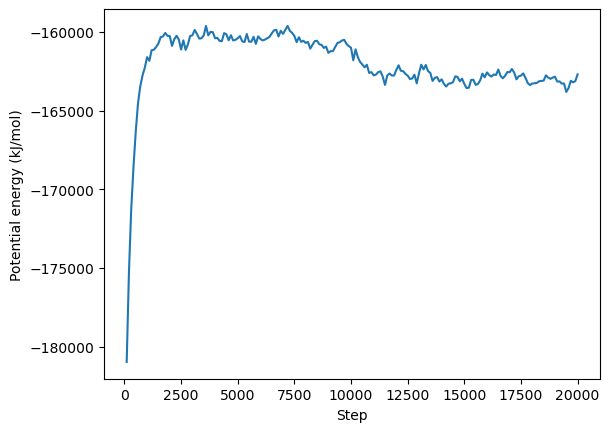

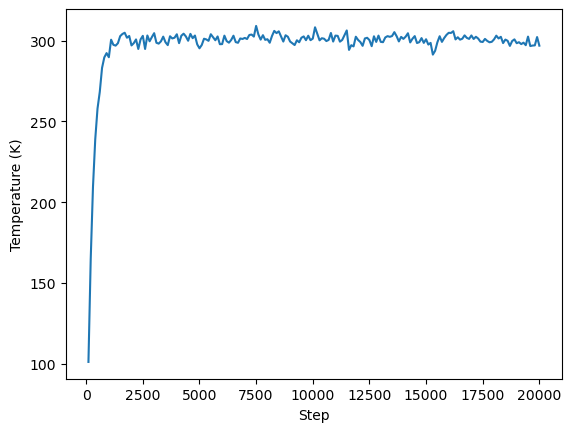

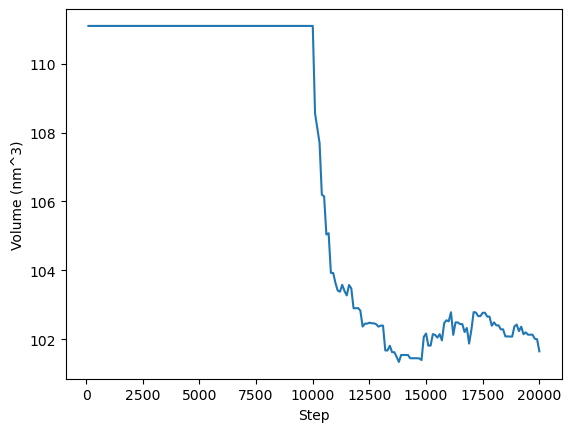

In [53]:
#Esta todo ok?
import numpy as np
import matplotlib.pyplot as plt
data = np.loadtxt("md_log.txt", delimiter=',')
step = data[:,0]
potential_energy = data[:,1]
temperature = data[:,2]
volume = data[:,3]
plt.plot(step, potential_energy)
plt.xlabel("Step")
plt.ylabel("Potential energy (kJ/mol)")
plt.show()
plt.plot(step, temperature)
plt.xlabel("Step")
plt.ylabel("Temperature (K)")
plt.show()
plt.plot(step, volume)
plt.xlabel("Step")
plt.ylabel("Volume (nm^3)")
plt.show()

# 2 Analisis
- Prody
- Mdtraj
- **MDAnalysis** (https://userguide.mdanalysis.org/stable/index.html)
- pytraj

## EJEMPLO CON adenylate kinase (AdK)

## ¿Que podemos hacer? ->Que queremos cuantificar
- RMSD -> ¿Que tan diferentes son dos universos?
- RMSF -¿cuánto se mueve cada parte de la proteína?
- Radio de giro -¿Como se distribuyen los atomos en f(x) del centro de masa?, compactación
- Distancias
- salt bridges 

Text(0, 0.5, 'RMSD ($\\AA$)')

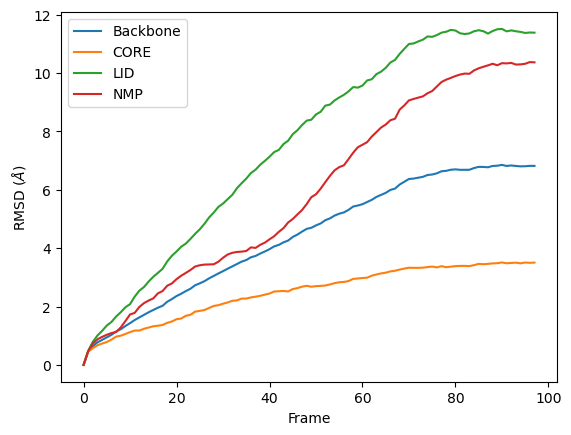

In [27]:
# RMSD
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD, CRD
from MDAnalysis.analysis import rms
import pandas as pd
%matplotlib inline
CORE = 'backbone and (resid 1-29 or resid 60-121 or resid 160-214)'
LID = 'backbone and resid 122-159'
NMP = 'backbone and resid 30-59'
R = rms.RMSD(u,  # universe to align
             u,  # reference universe or atomgroup
             select='backbone',  # group to superimpose and calculate RMSD
             groupselections=[CORE, LID, NMP],  # groups for RMSD
             ref_frame=0)  # frame index of the reference
R.run()
R.results.rmsd.shape
df = pd.DataFrame(R.results.rmsd,
                  columns=['Frame', 'Time (ns)',
                           'Backbone', 'CORE',
                           'LID', 'NMP'])

ax = df.plot(x='Frame', y=['Backbone', 'CORE', 'LID', 'NMP'],
             kind='line')
ax.set_ylabel(r'RMSD ($\AA$)')

In [29]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD, CRD, DCD2
from MDAnalysis.analysis import diffusionmap, align, rms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/home/blillo/miniconda3/envs/mdynamics/lib/python3.10/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


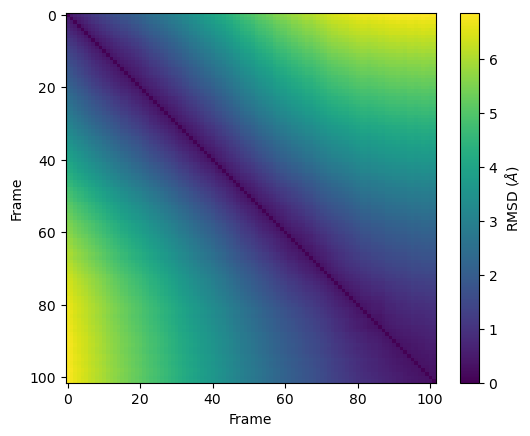

In [31]:
adk_open = mda.Universe(CRD, DCD2)
adk_closed = mda.Universe(PSF, DCD)
aligner = align.AlignTraj(adk_open, adk_open, select='name CA',
                          in_memory=True).run()
matrix = diffusionmap.DistanceMatrix(adk_open, select='name CA').run()
matrix.results.dist_matrix.shape
plt.imshow(matrix.results.dist_matrix, cmap='viridis')
plt.xlabel('Frame')
plt.ylabel('Frame')
plt.colorbar(label=r'RMSD ($\AA$)')

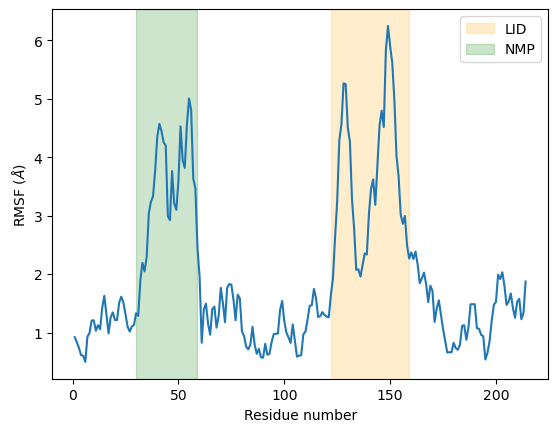

In [41]:
u = mda.Universe(CRD, DCD2)
average = align.AverageStructure(u, u, select='protein and name CA',
                                 ref_frame=0).run()
ref = average.results.universe
aligner = align.AlignTraj(u, ref,
                          select='protein and name CA',
                          in_memory=True).run()
c_alphas = u.select_atoms('protein and name CA')
R = rms.RMSF(c_alphas).run()
plt.plot(c_alphas.resids, R.results.rmsf)
plt.xlabel('Residue number')
plt.ylabel('RMSF ($\AA$)')
plt.axvspan(122, 159, zorder=0, alpha=0.2, color='orange', label='LID')
plt.axvspan(30, 59, zorder=0, alpha=0.2, color='green', label='NMP')
plt.legend()

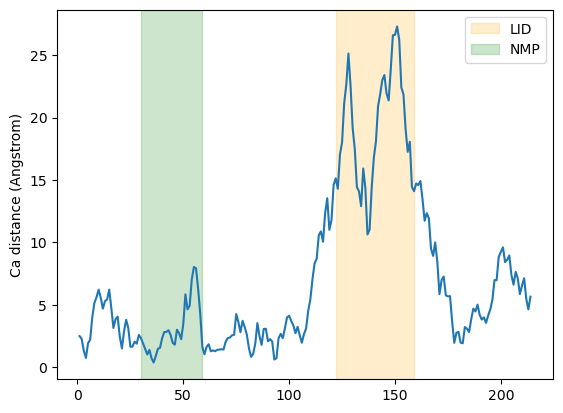

In [47]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PDB_small, PDB_closed
from MDAnalysis.analysis import distances

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
# suppress some MDAnalysis warnings when writing PDB files
warnings.filterwarnings('ignore')
u1 = mda.Universe(PDB_small)   # open AdK
u2 = mda.Universe(PDB_closed)  # closed AdK
ca1 = u1.select_atoms('name CA')
ca2 = u2.select_atoms('name CA')
resids1, resids2, dist = distances.dist(ca1, ca2,
                                        offset=0)  # for residue numbers
plt.plot(resids1, dist)
plt.ylabel('Ca distance (Angstrom)')
plt.axvspan(122, 159, zorder=0, alpha=0.2, color='orange', label='LID')
plt.axvspan(30, 59, zorder=0, alpha=0.2, color='green', label='NMP')
plt.legend()

There are 72 contacts in the reference.
[72. 39. 43. 33. 37.]


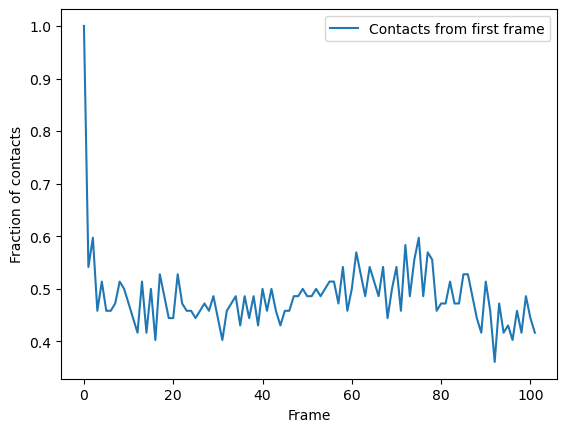

In [51]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD
from MDAnalysis.analysis import contacts

# import nglview as nv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
sel_basic = "(resname ARG LYS) and (name NH* NZ)"
sel_acidic = "(resname ASP GLU) and (name OE* OD*)"
acidic = u.select_atoms(sel_acidic)
basic = u.select_atoms(sel_basic)
ca1 = contacts.Contacts(u,
                        select=(sel_acidic, sel_basic),
                        refgroup=(acidic, basic),
                        radius=4.5,
                        method='hard_cut').run()
ca1_df = pd.DataFrame(ca1.results.timeseries,
                      columns=['Frame',
                               'Contacts from first frame'])
ca1_df.head()
ca1.initial_contacts[0].shape
n_ref = ca1.initial_contacts[0].sum()
print('There are {} contacts in the reference.'.format(n_ref))
n_contacts = ca1.results.timeseries[:, 1] * n_ref
print(n_contacts[:5])
ca1_df.plot(x='Frame')
plt.ylabel('Fraction of contacts')
plt.show()

Text(0, 0.5, 'Frequency')

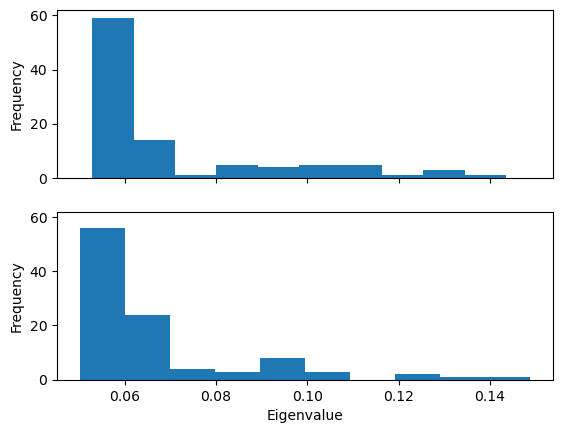

In [55]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD, DCD2
from MDAnalysis.analysis import gnm
import matplotlib.pyplot as plt
%matplotlib inline
u1 = mda.Universe(PSF, DCD)
u2 = mda.Universe(PSF, DCD2)
nma1 = gnm.GNMAnalysis(u1,
                      select='name CA',
                      cutoff=7.0)
nma1.run()
list(nma1.results.keys())
(len(nma1.results['eigenvalues']), len(nma1.results['eigenvectors']),
    len(nma1.results['times']))
nma2 = gnm.GNMAnalysis(u2,
                      select='name CA',
                      cutoff=7.0)
nma2.run()
histfig, histax = plt.subplots(nrows=2, sharex=True, sharey=True)
histax[0].hist(nma1.results['eigenvalues'])
histax[1].hist(nma2.results['eigenvalues'])

histax[1].set_xlabel('Eigenvalue')
histax[0].set_ylabel('Frequency')
histax[1].set_ylabel('Frequency')